### Feature selection is also known as Variable selection or Attribute selection.

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
np.set_printoptions(suppress=True)
pt = np.get_printoptions()['threshold']
from sklearn import datasets
from sklearn.feature_selection import VarianceThreshold

### Load Data

In [2]:
dataframe = pd.read_csv('sample_data/pokemon.csv')
dataframe.nunique()

#             721
Name          800
Type 1         18
Type 2         18
Total         200
HP             94
Attack        111
Defense       103
Sp. Atk       105
Sp. Def        92
Speed         108
Generation      6
Legendary       2
dtype: int64

In [3]:
dataframe.dtypes

#              int64
Name          object
Type 1        object
Type 2        object
Total          int64
HP             int64
Attack         int64
Defense        int64
Sp. Atk        int64
Sp. Def        int64
Speed          int64
Generation     int64
Legendary       bool
dtype: object

In [4]:
pokemon_features = dataframe.iloc[:,4:12]
pokemon_classes = dataframe['Legendary']
pokemon_X = np.array(pokemon_features)
pokemon_y = np.array(pokemon_classes).T
print('Feature set shape:', pokemon_X.shape)
print('Response class shape:', pokemon_y.shape)

Feature set shape: (800, 8)
Response class shape: (800,)


In [5]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(threshold=.15)
vt.fit(pokemon_X, pokemon_y)


feature_scores = [(item, score) for item, score in zip(pokemon_features, vt.variances_)]
sorted(feature_scores, key=lambda x: -x[1])[:10]

[('Total', 14373.141993749998),
 ('Sp. Atk', 1069.4101),
 ('Attack', 1052.1637484375),
 ('Defense', 971.19519375),
 ('Speed', 843.4554937500001),
 ('Sp. Def', 773.48049375),
 ('HP', 651.2042984374999),
 ('Generation', 2.7564359375000005)]

### Verifying the scores

In [6]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(pokemon_X, pokemon_y)


# In[18]:

importance_scores = rfc.feature_importances_
feature_importances = [(feature, score) for feature, score in zip(pokemon_features, importance_scores)]
sorted(feature_importances, key=lambda x: -x[1])[:10]

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[('Total', 0.3019731326109035),
 ('Attack', 0.12504328502682122),
 ('Sp. Atk', 0.12494764094743886),
 ('HP', 0.11134669784116821),
 ('Speed', 0.1093949188397328),
 ('Sp. Def', 0.09732108276613102),
 ('Defense', 0.07430076317886332),
 ('Generation', 0.055672478788941084)]

As seen from the variance scores Total, Sp. Atk, Attack, Defence are the top four features which decides a pokemon's ability to be legendary.

### Feature Correlation Analysis

In [7]:
corr_matrix = dataframe.corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                 .stack()
                 .sort_values(ascending=False))

#Priniting the highly correlated pairs
print(sol)

#           Generation    0.982516
Total       Sp. Atk       0.747250
            Attack        0.736211
            Sp. Def       0.717609
            HP            0.618748
            Defense       0.612787
            Speed         0.575943
Defense     Sp. Def       0.510747
Sp. Atk     Sp. Def       0.506121
Total       Legendary     0.501758
Sp. Atk     Speed         0.473018
            Legendary     0.448907
Attack      Defense       0.438687
HP          Attack        0.422386
Attack      Sp. Atk       0.396362
            Speed         0.381240
HP          Sp. Def       0.378718
Sp. Def     Legendary     0.363937
HP          Sp. Atk       0.362380
Attack      Legendary     0.345408
Speed       Legendary     0.326715
HP          Legendary     0.273620
Attack      Sp. Def       0.263990
Sp. Def     Speed         0.259133
Defense     Legendary     0.246377
HP          Defense       0.239622
Defense     Sp. Atk       0.223549
HP          Speed         0.175952
#           Legendar

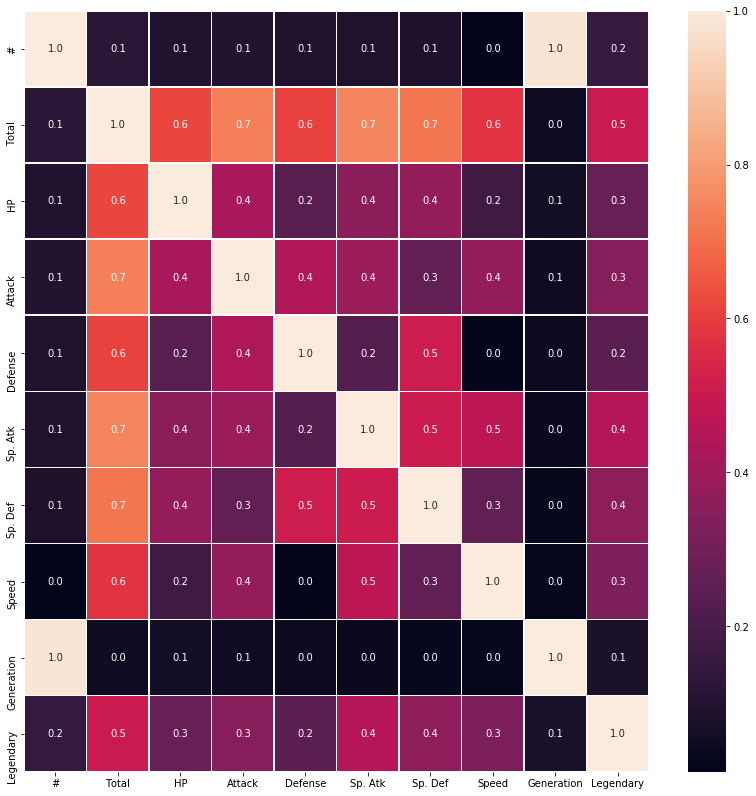

In [8]:
#correlation map
f,ax = plt.subplots(figsize=(14, 14))
sns.heatmap(corr_matrix, annot=True, linewidths=.5, fmt= '.1f',ax=ax)


As we can see Defense-Sp. Def  , Sp. Atk-Sp. Def , Total-Legendary  are moderately correlated

# Filter Methods 

Filter methods are generally used as a preprocessing step. The selection of features is independent of any machine learning algorithms. Instead, features are selected on the basis of their scores in various statistical tests for their correlation with the outcome variable. The correlation is a subjective term here. For basic guidance, you can refer to the following table for defining correlation co-efficients.





![FS1.webp](attachment:FS1.webp)

<b>Pearson’s Correlation:</b> It is used as a measure for quantifying linear dependence between two continuous variables X and Y. Its value varies from -1 to +1. Pearson’s correlation is given as:


![FS2.webp](attachment:FS2.webp)


<b>LDA:</b> Linear discriminant analysis is used to find a linear combination of features that characterizes or separates two or more classes (or levels) of a categorical variable.

<b>ANOVA:</b> ANOVA stands for Analysis of variance. It is similar to LDA except for the fact that it is operated using one or more categorical independent features and one continuous dependent feature. It provides a statistical test of whether the means of several groups are equal or not.

<b>Chi-Square:</b> It is a is a statistical test applied to the groups of categorical features to evaluate the likelihood of correlation or association between them using their frequency distribution.
One thing that should be kept in mind is that filter methods do not remove multicollinearity. So, you must deal with multicollinearity of features as well before training models for your data.

# Variable Types

<h3>Categorical variable</h3>

Categorical variables contain a finite number of categories or distinct groups. Categorical data might not have a logical order. For example, categorical predictors include gender, material type, and payment method.

<h3>Continuous variable</h3>

Continuous variables are numeric variables that have an infinite number of values between any two values. A continuous variable can be numeric or date/time. For example, the length of a part or the date and time a payment is received.


#### Identifying the categorical variables in the data

In [9]:
likely_cat = [var for var in dataframe.columns if 
dataframe[var].nunique()/dataframe[var].count() < 0.05] # can take some other threshold

print("The categorical variables are: "+str(likely_cat))


The categorical variables are: ['Type 1', 'Type 2', 'Generation', 'Legendary']


#### Identifying the continuous variables in the data

In [10]:
likely_cont = [var for var in dataframe.columns if 
dataframe[var].nunique()/dataframe[var].count() > 0.05] # can take some other threshold

print("The continuous variables are: "+str(likely_cont))

The continuous variables are: ['#', 'Name', 'Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']


# One Hot Encoding

Machine learning algorithms cannot work with categorical data directly. Categorical data must be converted to numbers. This applies when you are working with a sequence classification type problem and plan on using deep learning methods such as Long Short-Term Memory recurrent neural networks.

A one hot encoding is a representation of categorical variables as binary vectors. <br>
This first requires that the categorical values be <b>mapped to integer values</b>.
Then, each integer value is represented as a binary vector that is all <b>zero</b> values <b>except the index of the integer</b>, which is marked with a 1.

Lets perform a one hot encoding on our categorical data

In [11]:
dataframe

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
5,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,1,False
6,6,Charizard,Fire,Flying,534,78,84,78,109,85,100,1,False
7,6,CharizardMega Charizard X,Fire,Dragon,634,78,130,111,130,85,100,1,False
8,6,CharizardMega Charizard Y,Fire,Flying,634,78,104,78,159,115,100,1,False
9,7,Squirtle,Water,NaN,314,44,48,65,50,64,43,1,False


In [12]:
pd.get_dummies(dataframe,prefix=likely_cat,columns = likely_cat) #use the get_dummies() from pandas for one hot encoding

,#,Name,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Type 1_Bug,Type 1_Dark,Type 1_Dragon,Type 1_Electric,Type 1_Fairy,Type 1_Fighting,Type 1_Fire,Type 1_Flying,Type 1_Ghost,Type 1_Grass,Type 1_Ground,Type 1_Ice,Type 1_Normal,Type 1_Poison,Type 1_Psychic,Type 1_Rock,Type 1_Steel,Type 1_Water,Type 2_Bug,Type 2_Dark,Type 2_Dragon,Type 2_Electric,Type 2_Fairy,Type 2_Fighting,Type 2_Fire,Type 2_Flying,Type 2_Ghost,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water,Generation_1,Generation_2,Generation_3,Generation_4,Generation_5,Generation_6,Legendary_False,Legendary_True
0,1,Bulbasaur,318,45,49,49,65,65,45,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
1,2,Ivysaur,405,60,62,63,80,80,60,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
2,3,Venusaur,525,80,82,83,100,100,80,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
3,3,VenusaurMega Venusaur,625,80,100,123,122,120,80,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
4,4,Charmander,309,39,52,43,60,50,65,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
5,5,Charmeleon,405,58,64,58,80,65,80,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
6,6,Charizard,534,78,84,78,109,85,100,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
7,6,CharizardMega Charizard X,634,78,130,111,130,85,100,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
8,6,CharizardMega Charizard Y,634,78,104,78,159,115,100,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
9,7,Squirtle,314,44,48,65,50,64,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


<h1>Recursive Feature Elimination</h1>

The Recursive Feature Elimination (or RFE) works by recursively removing attributes and building a model on those attributes that remain.

It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.



The example below uses RFE with the logistic regression algorithm to select the top 3 features. The choice of algorithm does not matter too much as long as it is skillful and consistent.

In [13]:
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 3)
fit = rfe.fit(pokemon_X, pokemon_y)
selected_features = [val for idx,val in enumerate(pokemon_features.columns) if fit.support_[idx]]
print("Num Features: "+ str(fit.n_features_))  
print("Selected Features: "+ str(selected_features)) 
print("All Features: "+ str(list(pokemon_features.columns)))
print("Feature Ranking: " + str(fit.ranking_))  


Num Features: 3
Selected Features: ['Total', 'HP', 'Sp. Atk']
All Features: ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Generation']
Feature Ranking: [1 1 6 2 1 3 5 4]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur